In [479]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [480]:
european_matches = pd.read_csv('data/cleaned/european_matches.csv')

In [481]:
european_matches.head()

,date,home_win,home_player_1_overall_rating,home_player_1_potential,home_player_1_preferred_foot,home_player_1_attacking_work_rate,home_player_1_defensive_work_rate,home_player_1_crossing,home_player_1_finishing,home_player_1_heading_accuracy,...,wins_past_1_games,not_enough_past_games_1,wins_past_2_games,not_enough_past_games_2,wins_past_3_games,not_enough_past_games_3,wins_past_4_games,not_enough_past_games_4,wins_past_5_games,not_enough_past_games_5
0,2008-08-17 00:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1
1,2008-08-16 00:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1
2,2008-08-16 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1
3,2008-08-17 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1
4,2008-08-16 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,1,0,1,0,1


In [482]:
player_columns = [column.split('11')[-1] for column in european_matches.columns if "home_player_11" in column]
player_columns

['_overall_rating',
 '_potential',
 '_preferred_foot',
 '_attacking_work_rate',
 '_defensive_work_rate',
 '_crossing',
 '_finishing',
 '_heading_accuracy',
 '_short_passing',
 '_volleys',
 '_dribbling',
 '_curve',
 '_free_kick_accuracy',
 '_long_passing',
 '_ball_control',
 '_acceleration',
 '_sprint_speed',
 '_agility',
 '_reactions',
 '_balance',
 '_shot_power',
 '_jumping',
 '_stamina',
 '_strength',
 '_long_shots',
 '_aggression',
 '_interceptions',
 '_positioning',
 '_vision',
 '_penalties',
 '_marking',
 '_standing_tackle',
 '_sliding_tackle',
 '_gk_diving',
 '_gk_handling',
 '_gk_kicking',
 '_gk_positioning',
 '_gk_reflexes']

In [483]:
def drop_columns_below_threshold(df, na_columns, threshold):
    """
    Drop rows with too many NAs in specified columns. threshold is min number of columns we want to have non-NA values.
    """
    df = df.copy()
    #Keep rows with number of non-NA values above threshold in specified columns
    keep_indices = df[na_columns].dropna(thresh = threshold).index
    return df.loc[keep_indices]

In [484]:
home_rating_columns = ['home_player_{}_overall_rating'.format(i) for i in range(1, 12)]
away_rating_columns = ['away_player_{}_overall_rating'.format(i) for i in range(1, 12)]


european_matches = drop_columns_below_threshold(european_matches, home_rating_columns + away_rating_columns, 11)

In [485]:
diff_cols = []
for player_column in player_columns:
    home_cols = european_matches[['home_player_{}{}'.format(i, player_column) for i in range(2, 12)]].copy()
    away_cols = european_matches[['away_player_{}{}'.format(i, player_column) for i in range(2, 12)]].copy()
    #numeric column
    if np.issubdtype(european_matches['home_player_11{}'.format(player_column)].dtype, np.number):
        #since only one goal keeper, we just get max stat
        if 'gk' in player_column:
            european_matches['home{}'.format(player_column)] = home_cols.max(axis = 1)
            european_matches['away{}'.format(player_column)] = away_cols.max(axis = 1)        
            european_matches['diff{}'.format(player_column)] =  european_matches['home{}'.format(player_column)] - \
                                                                european_matches['away{}'.format(player_column)]
        else:
            european_matches['home{}'.format(player_column)] = home_cols.mean(axis = 1)
            european_matches['away{}'.format(player_column)] = away_cols.mean(axis = 1)
            european_matches['diff{}'.format(player_column)] =  european_matches['home{}'.format(player_column)] - \
                                                                european_matches['away{}'.format(player_column)]
        diff_cols.append('diff{}'.format(player_column))
    #non-numeric column
    else:
        continue 

In [486]:
len(diff_cols)

35

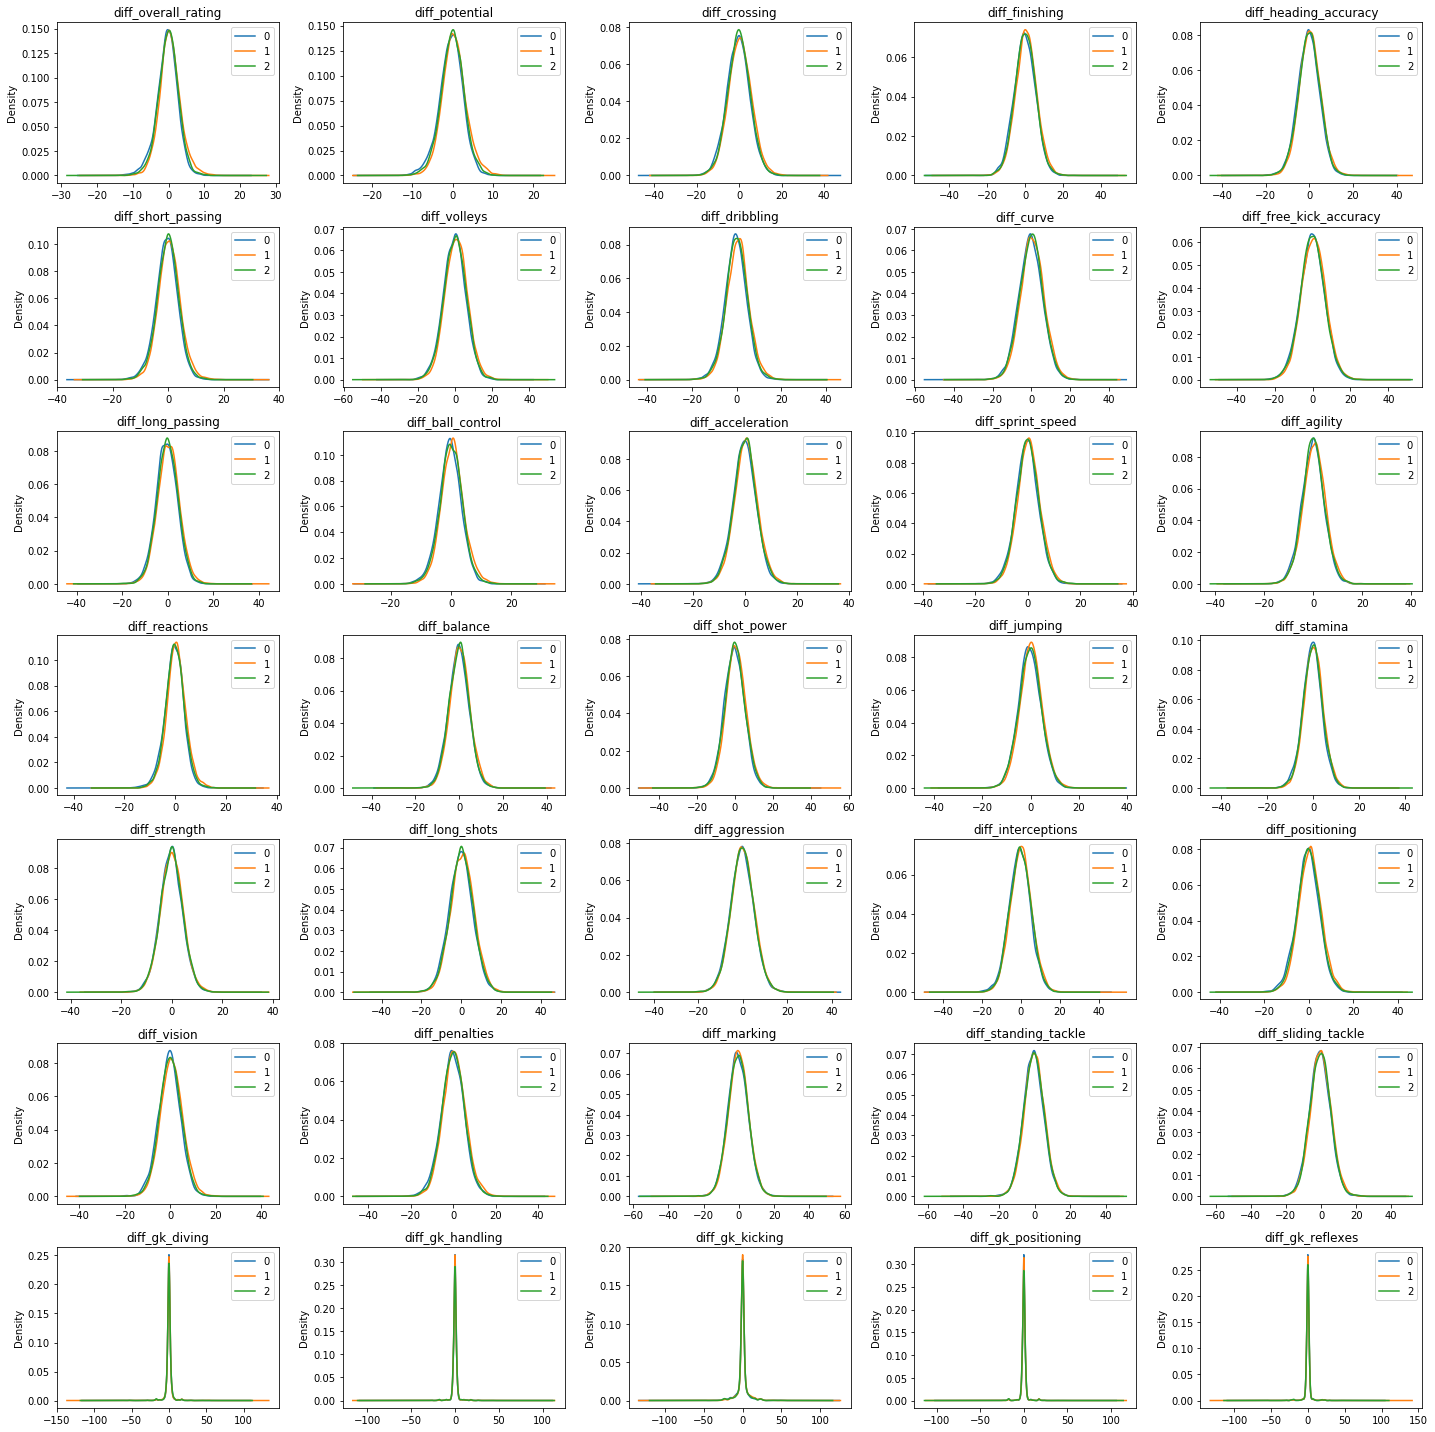

In [496]:
fig, axes = plt.subplots(7, 5, figsize = (20, 20))
axes = axes.flatten()
for label, df in european_matches.groupby('home_win'):
    for i, col in enumerate(diff_cols):
        df[col].plot.kde(label=label, ax = axes[i])
        axes[i].set_title(col)
        axes[i].legend()
plt.tight_layout();

In [476]:
for i in range(1, 6):
    european_matches['diff_wins_past_{}_games'.format(i)] = (european_matches['home_wins_past_{}_games'.format(i)] -\
                                                             european_matches['away_wins_past_{}_games'.format(i)])
    diff_cols.append('diff_wins_past_{}_games'.format(i))

#https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
past_wins_columns = [['wins_past_{}_games'.format(i), 'not_enough_past_games_{}'.format(i)] for i in range(1, 6)]
past_wins_columns = [item for sublist in past_wins_columns for item in sublist]
past_wins_columns

['wins_past_1_games',
 'not_enough_past_games_1',
 'wins_past_2_games',
 'not_enough_past_games_2',
 'wins_past_3_games',
 'not_enough_past_games_3',
 'wins_past_4_games',
 'not_enough_past_games_4',
 'wins_past_5_games',
 'not_enough_past_games_5']

In [477]:
european_matches.columns

Index(['date', 'home_win', 'home_player_1_overall_rating',
       'home_player_1_potential', 'home_player_1_preferred_foot',
       'home_player_1_attacking_work_rate',
       'home_player_1_defensive_work_rate', 'home_player_1_crossing',
       'home_player_1_finishing', 'home_player_1_heading_accuracy',
       ...
       'away_gk_positioning', 'diff_gk_positioning', 'home_gk_reflexes',
       'away_gk_reflexes', 'diff_gk_reflexes', 'diff_wins_past_1_games',
       'diff_wins_past_2_games', 'diff_wins_past_3_games',
       'diff_wins_past_4_games', 'diff_wins_past_5_games'],
      dtype='object', length=978)

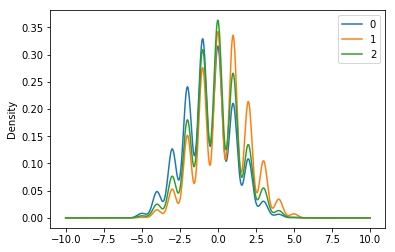

In [465]:
for label, df in european_matches.groupby('home_win'):
    df.diff_wins_past_5_games.plot(kind="kde", label=label)
    plt.legend();

In [466]:
european_matches.groupby('home_win')['diff_wins_past_4_games'].mean()

home_win
0   -0.486096
1    0.239902
2   -0.142429
Name: diff_wins_past_4_games, dtype: float64

In [467]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [468]:
y = european_matches['home_win'].values
X = european_matches[diff_cols + past_wins_columns].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


In [472]:
logit_model = LogisticRegressionCV(max_iter=1000, cv = 5, multi_class = 'multinomial').fit(X_train, y_train)
print(logit_model.score(X_train, y_train))
print(logit_model.score(X_val, y_val))

0.4912667033681998
0.4797838270616493


In [394]:
rf_model = RandomForestClassifier(n_estimators = 30).fit(X_train, y_train)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_val, y_val))

0.47054701966868523
0.4677742193755004


In [395]:
ada_model = AdaBoostClassifier().fit(X_train, y_train)
print(ada_model.score(X_train, y_train))
print(ada_model.score(X_val, y_val))

0.4703468294880136
0.46657325860688553
